# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%shell

rm -rf object-detection | true
git clone -b model/R-CNN  https://github.com/Howard-O-Neil/object-detection.git

Cloning into 'object-detection'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 108 (delta 43), reused 81 (delta 20), pack-reused 0
Receiving objects: 100% (108/108), 616.48 KiB | 3.71 MiB/s, done.
Resolving deltas: 100% (43/43), done.


In [3]:
%%shell

mv object-detection/model_cifa10 /content/
mv object-detection/model_imagenet /content/ 
ls -a

.   .config  model_cifa10    object-detection
..  drive    model_imagenet  sample_data


In [4]:
import pickle
import json
import numpy as np
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import pandas as pd
import seaborn as sb
import scipy as sp
import sklearn.preprocessing as skp
import skimage
import skimage.io
import skimage.transform
import numpy as np
import cv2

import sys

np.set_printoptions(threshold=sys.maxsize)

In [5]:
MODEL_ID = 1
DATA_DIR = "/content/drive/My Drive/dataset/imagenet"

# Load model

In [6]:
import model_cifa10.file_utils as file_utils
LABEL_PATH = f"{DATA_DIR}/LOC_synset_mapping.txt"

labels = np.array([["", ""]])

f = os.open(LABEL_PATH, os.O_RDONLY)
res = os.read(f, os.path.getsize(LABEL_PATH)).decode("utf-8")

for label_str in res.split("\n")[0:-1]:
    arr = np.expand_dims(np.array(label_str.split(" ", 1)), 0)
    labels = np.concatenate((labels, arr), axis=0)

labels = labels[1:, :]

In [7]:
from model_imagenet.model import predict_model

def compute_labels(data, labels):
    predict_res = predict_model.predict_on_batch(
        tf.image.resize(
            data,
            [224, 224], method="lanczos5")
    )
    return labels[np.argmax(predict_res, 1)]

def compute_probs(data):
    predict_res = predict_model.predict_on_batch(
        tf.image.resize(
            data,
            [224, 224], method="lanczos5")
    )
    return np.amax(predict_res, 1)

553476096/553467096 [==============================] - 15s 0us/step


# Classify images

===== RAW IMAGE =====
(1600, 2400, 3)


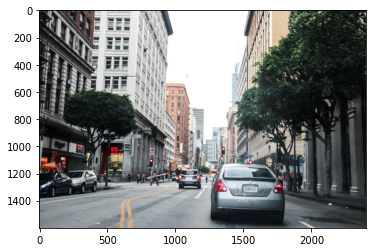

===== AFTER SCALE =====
(1600, 2400, 3)


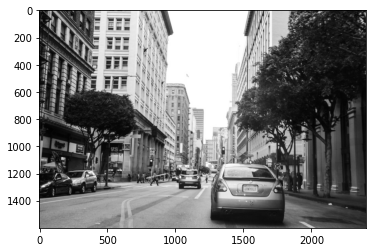

===== LABEL ['n02930766' 'cab, hack, taxi, taxicab']
===== PROBABILITY [0.58343023]


In [32]:
img_path = "/content/drive/My Drive/Image/car_1.jpeg"

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print("===== RAW IMAGE =====")
print(image.shape)
plt.imshow(image)
plt.show()

print("===== AFTER SCALE =====")
feed_img = np.tile(
    tf.image.rgb_to_grayscale(image), (1, 1, 3)
)
print(feed_img.shape)
plt.imshow(feed_img)
plt.show()

feed_img = np.expand_dims(feed_img, 0)
_label = np.squeeze(compute_labels(feed_img, labels))
print(f"===== LABEL {_label}")
print(f"===== PROBABILITY {compute_probs(feed_img)}")

# Selective Search

===== RAW IMAGE =====
(1600, 2400, 3)


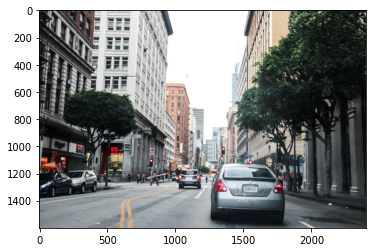

===== AFTER SCALE =====
(224, 336, 3)


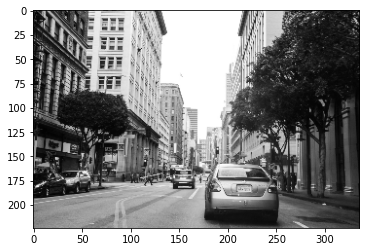

In [83]:
img_path = "/content/drive/My Drive/Image/car_1.jpeg"

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print("===== RAW IMAGE =====")
print(image.shape)
plt.imshow(image)
plt.show()

print("===== AFTER SCALE =====")
rescale_img_color = cv2.resize(
    image, (0, 0), fx=224.0 / image.shape[0], fy=224.0 / image.shape[0]
)

rescale_img = np.tile(
    tf.image.rgb_to_grayscale(
        cv2.resize(
            image, (0, 0), fx=224.0 / image.shape[0], fy=224.0 / image.shape[0]
        )
    ),
    (1, 1, 3)
) 

print(rescale_img.shape)
plt.imshow(rescale_img)
plt.show()

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

ss.setBaseImage(rescale_img)
ss.switchToSelectiveSearchFast() # reduce number of boxes

boxes = ss.process()

(890, 4)


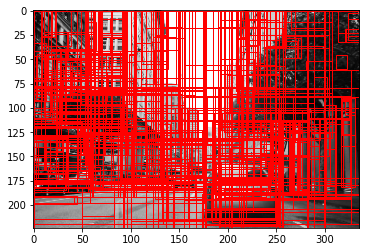

In [84]:
import matplotlib.patches as mpatches

print(boxes.shape)

fig, ax = plt.subplots(1)
ax.imshow(rescale_img)

for i, rect in enumerate(boxes):
    r = mpatches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=1, edgecolor='r', facecolor="none")
    ax.add_patch(r)

plt.show()

In [85]:
list_probs = []
for i, rect in enumerate(boxes):
    _y = rect[1]
    _h = rect[3]
    _x = rect[0]
    _w = rect[2]
    
    feed_img = np.expand_dims(
        rescale_img[_y:_y+_h, _x:_x+_w], 0
    )

    list_probs.append([
        i,
        np.squeeze(compute_labels(feed_img, labels)),
        compute_probs(feed_img)
    ])

In [86]:
list_probs.sort(
    key=lambda x: x[2]
)
list_probs = list_probs[::-1]

['n02930766' 'cab, hack, taxi, taxicab'] [0.85447425]
['n02930766' 'cab, hack, taxi, taxicab'] [0.7870322]
['n02930766' 'cab, hack, taxi, taxicab'] [0.7671127]
['n02930766' 'cab, hack, taxi, taxicab'] [0.75264126]
['n02930766' 'cab, hack, taxi, taxicab'] [0.7469973]
['n02930766' 'cab, hack, taxi, taxicab'] [0.7365624]
['n02930766' 'cab, hack, taxi, taxicab'] [0.735112]
['n02930766' 'cab, hack, taxi, taxicab'] [0.73388976]
['n02930766' 'cab, hack, taxi, taxicab'] [0.7130024]
['n02930766' 'cab, hack, taxi, taxicab'] [0.71116465]


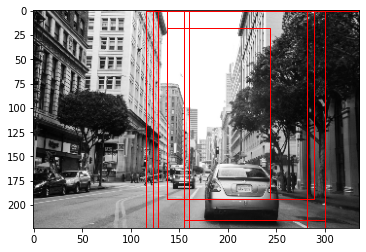

In [89]:
fig, ax = plt.subplots(1)
ax.imshow(rescale_img)

for i, area in enumerate(list_probs[0:1000]):
    if any(x in area[1][1] for x in ["cab", "car"]) and area[2] > 0.7:
        print(f"{area[1]} {area[2]}")
        rect = boxes[area[0]]
        r = mpatches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=1, edgecolor='r', facecolor="none")
        ax.add_patch(r)

plt.show()